In [291]:
import dolfin as dl
import numpy as np
import pandas as pd

# from datetime import datetime
import datetime
# from seird_problem import seird_fwd_problem
# from seird_initial_with_recovered import generate_initial_condition

import os
import sys
import copy

import argparse
import timeit

In [292]:
import pyvista as pv
import geopandas as gpd
from shapely.geometry import Point
from descartes import PolygonPatch

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set_style("white")
sns.set_style("ticks")

In [294]:
STATE = 0
PARAMETER = 1

mesh_path = '../../Data/mesh/'
data_path = '../../Data/covid_11August2020/'

num_sim = 20
sim_id = 0

date = "2020-07-15"

# Plot QoI on map

## Load district geometry data

In [295]:
dist_process_path = '../../PreProcess/district_data/'
county_process_path = '../../PreProcess/county_data/'

sys.path.insert(0, dist_process_path)
sys.path.insert(1, county_process_path)

from read_district_data import *
from read_county_data import *

# get county data
county_nms, county_dist, county_dist_names, county_polys = read_county_map(county_process_path + '/data/')

# get district data
new_dist_nm, new_dist_county_nbr, new_dist_county_nm, new_dist_geom = read_dist_map(dist_process_path + '/data/', 
                                                county_nms, county_dist, 
                                                  county_dist_names, county_polys, 0)

In [296]:
# load vtk file
mesh_fname='mesh_5h'
mesh = pv.read(mesh_path + mesh_fname + '.vtk')

mesh_nodes = mesh.points
mesh_elems = mesh.cells

In [297]:
DATA_DAY_BEGIN = [15, 7, 2020]
date_start = datetime.datetime(year = DATA_DAY_BEGIN[2], month=DATA_DAY_BEGIN[1], day = DATA_DAY_BEGIN[0])

def get_sim_date(day):
    return date_start + datetime.timedelta(days=int(day))

def diff_day(d1, d2):
    a = datetime.datetime.strptime(d1, "%Y-%m-%d")
    b = datetime.datetime.strptime(d2, "%Y-%m-%d")
    return abs((b-a)).days

print(get_sim_date(47))

2020-08-31 00:00:00


In [298]:
# join qoi to get one qoi and also read data
pred_qoi = np.load('qoi_mcmc_9/qoi_0.npy')
calib_data = np.load('qoi_mcmc_9/data.npy')

total_exp = pred_qoi.shape[0]

for i in range(19):
    qn = np.load('qoi_mcmc_9/qoi_' + str(i+1) + '.npy')
    total_exp += qn.shape[0]
    
    pred_qoi = np.append(pred_qoi, qn, axis=0)
    
    
print('expect total: {} actual total: {}'.format(total_exp, pred_qoi.shape[0]))
print(pred_qoi.shape)

expect total: 400 actual total: 400
(400, 63, 26, 2)


In [299]:
calib_data.shape

(25, 2)

In [300]:
# state prediction
pred_state = []
for i in range(pred_qoi.shape[1]):

    d = [0., 0.]
    for j in range(pred_qoi.shape[0]):
        for k in range(2):
            d[k] += pred_qoi[j, i, -1, k]
    
    for k in range(2):
        d[k] = d[k]/pred_qoi.shape[0]
    
    pred_state.append(d)

pred_state = np.array(pred_state)

In [301]:
pred_state[-1]

array([424860.20660327,   9525.24050147])

In [302]:
pred_state[48]

array([425873.31029401,   9420.74708003])

In [303]:
#old prediction results

# join qoi to get one qoi and also read data
pred_old_path = '../prediction_results/prediction_qoi_from_validation_posterior_samples/'
pred_old_qoi = np.load(pred_old_path+'qoi_0.npy')

total_exp = pred_old_qoi.shape[0]

for i in range(4):
    qn = np.load(pred_old_path+'qoi_' + str(i+1) + '.npy')
    total_exp += qn.shape[0]
    
    pred_old_qoi = np.append(pred_old_qoi, qn, axis=0)
    
    
print('expect total: {} actual total: {}'.format(total_exp, pred_old_qoi.shape[0]))
print(pred_old_qoi.shape)

expect total: 2940 actual total: 2940
(2940, 110, 26, 2)


In [304]:
#truncate data
old_sim_start = "2020-06-01"
new_sim_start = "2020-07-15"
old_to_new_start_day = diff_day(old_sim_start, new_sim_start)
print(old_to_new_start_day)

44


In [305]:
get_sim_date(62)

datetime.datetime(2020, 9, 15, 0, 0)

In [306]:
pred_old_qoi = pred_old_qoi[:, 44:, :, :]

In [307]:
print(pred_old_qoi.shape)

(2940, 66, 26, 2)


In [308]:
pred_old_qoi = pred_old_qoi[:, :-3, :, :]

In [309]:
print(pred_old_qoi.shape)

(2940, 63, 26, 2)


In [310]:
# state prediction
pred_old_state = []
for i in range(pred_old_qoi.shape[1]):

    d = [0., 0.]
    for j in range(pred_old_qoi.shape[0]):
        for k in range(2):
            d[k] += pred_old_qoi[j, i, -1, k]
    
    for k in range(2):
        d[k] = d[k]/pred_old_qoi.shape[0]
    
    pred_old_state.append(d)

pred_old_state = np.array(pred_old_state)

In [311]:
pred_old_state[-1]

array([289641.96383562,   6677.08813617])

# plot of state QoI 

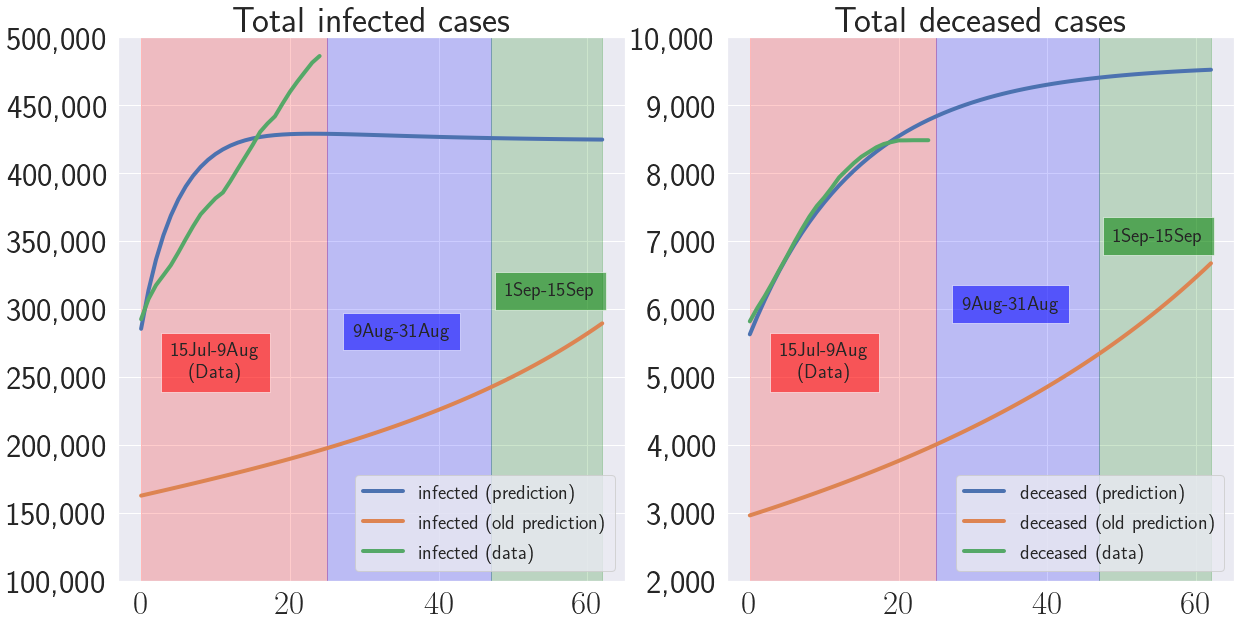

In [312]:
# plot
sns.set(font_scale=3)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# infected
axs[0].plot(pred_state[:, 0], label = r'infected (prediction)', linewidth = 4)
axs[0].plot(pred_old_state[:, 0], label = r'infected (old prediction)', linewidth = 4)
axs[0].plot(calib_data[:,0], label = r'infected (data)', linewidth = 4)

# axs[0].arrow(14, calib_data[14,0], 2, -0.1*calib_data[14,0], 
#              width=1, edgecolor='green', shape='right', head_width = 5)
# axs[0].text(17, 0.8*calib_data[15,0], "data", ha='center', fontsize=20, 
#             bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

axs[0].text(10, 250000, "15Jul-9Aug\n(Data)", ha='center', fontsize=20, 
            bbox={'facecolor': 'red', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=25, linewidth=1.5, alpha=0.75, color='r')
axs[0].axvspan(0, 25, alpha=0.2, color='red')

axs[0].text(35, 280000, "9Aug-31Aug", ha='center', fontsize=20, 
            bbox={'facecolor': 'blue', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=47, linewidth=1.5, alpha=0.75, color='b')
axs[0].axvspan(25, 47, alpha=0.2, color='blue')

axs[0].text(55, 310000, "1Sep-15Sep", ha='center', fontsize=20, 
            bbox={'facecolor': 'green', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=62, linewidth=1.5, alpha=0.75, color='g')
axs[0].axvspan(47, 62, alpha=0.2, color='green')

axs[0].legend(fontsize = 20, fancybox=True)

axs[0].set_ylim(100000, 500000)
axs[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

axs[0].set_title('Total infected cases')

# deceased
axs[1].plot(pred_state[:, 1], label = r'deceased (prediction)', linewidth = 4)
axs[1].plot(pred_old_state[:, 1], label = r'deceased (old prediction)', linewidth = 4)
axs[1].plot(calib_data[:,1], label = r'deceased (data)', linewidth = 4)

axs[1].text(10, 5000, "15Jul-9Aug\n(Data)", ha='center', fontsize=20, 
            bbox={'facecolor': 'red', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=25, linewidth=1.5, alpha=0.75, color='r')
axs[1].axvspan(0, 25, alpha=0.2, color='red')

axs[1].text(35, 6000, "9Aug-31Aug", ha='center', fontsize=20, 
            bbox={'facecolor': 'blue', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=47, linewidth=1.5, alpha=0.75, color='b')
axs[1].axvspan(25, 47, alpha=0.2, color='blue')

axs[1].text(55, 7000, "1Sep-15Sep", ha='center', fontsize=20, 
            bbox={'facecolor': 'green', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=62, linewidth=1.5, alpha=0.75, color='g')
axs[1].axvspan(47, 62, alpha=0.2, color='green')

axs[1].legend(fontsize = 20, fancybox=True)

axs[1].set_ylim(2000, 10000)
axs[1].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

axs[1].set_title('Total deceased cases')

plt.savefig('new_prediction_until_15Sep_mcmc_9.png')
plt.show()

# Compute CI from QoI

In [286]:
import scipy.stats

def mean_confidence_interval(data):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h1 = se * scipy.stats.t.ppf((1 + 0.68) / 2., n-1)
    h2 = se * scipy.stats.t.ppf((1 + 0.95) / 2., n-1)
    return np.array([m, h1, h2])

In [287]:
total_qoi_evolution = np.zeros((63, 26, 3, 2))
for i in range (63):
    for j in range (26):
        for k in range (2):
            total_qoi_evolution[i,j,:,k] = mean_confidence_interval(pred_qoi[:, i, j, k])

In [289]:
total_qoi_evolution[48, -1, 0, 0], total_qoi_evolution[48, -1, 1, 0], total_qoi_evolution[48, -1, 2, 0]

(425873.31029401365, 1099.5039193500597, 2170.882323283551)

In [290]:
total_qoi_evolution[48, -1, 0, 1], total_qoi_evolution[48, -1, 1, 1], total_qoi_evolution[48, -1, 2, 1]

(9420.747080033872, 18.919887228459693, 37.3558002112993)

In [271]:
top_district = [1, 14, 13, 17, 11]
for i in range(5):
    print(district_names[top_district[i]])

Fort Worth
San Antonio
Austin
Dallas
Houston


# Plot of state QoI with confidence interval

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (18,6))
for col in range (2):
    ax[col].fill_between(np.arange(92-30)+31, total_qoi_evolution[30:92, -1, 0, col] + total_qoi_evolution[30:92, -1, 2, col],\
                         total_qoi_evolution[30:92, -1, 0, col] - total_qoi_evolution[30:92, -1, 2, col],\
                         alpha=0.2, edgecolor='b', facecolor='b', label = r'$95\%$ CI')
    ax[col].fill_between(np.arange(92-30)+31, total_qoi_evolution[30:92, -1, 0, col] + total_qoi_evolution[30:92, -1, 1, col],\
                         total_qoi_evolution[30:92, -1, 0, col] - total_qoi_evolution[30:92, -1, 1, col],\
                         alpha=0.2, edgecolor='r', facecolor='r', label = r'$68\%$ CI')
    ax[col].plot(np.arange(92-30)+31, total_qoi_evolution[30:92, -1, 0, col], "g-", label = r'mean')
    ax[col].legend(loc="lower right", fancybox=True)
    ax[col].set_xlabel(r"Days")
    
ax[0].set_ylabel(r"Total infected cases")
ax[1].set_ylabel(r"Total decased cases")

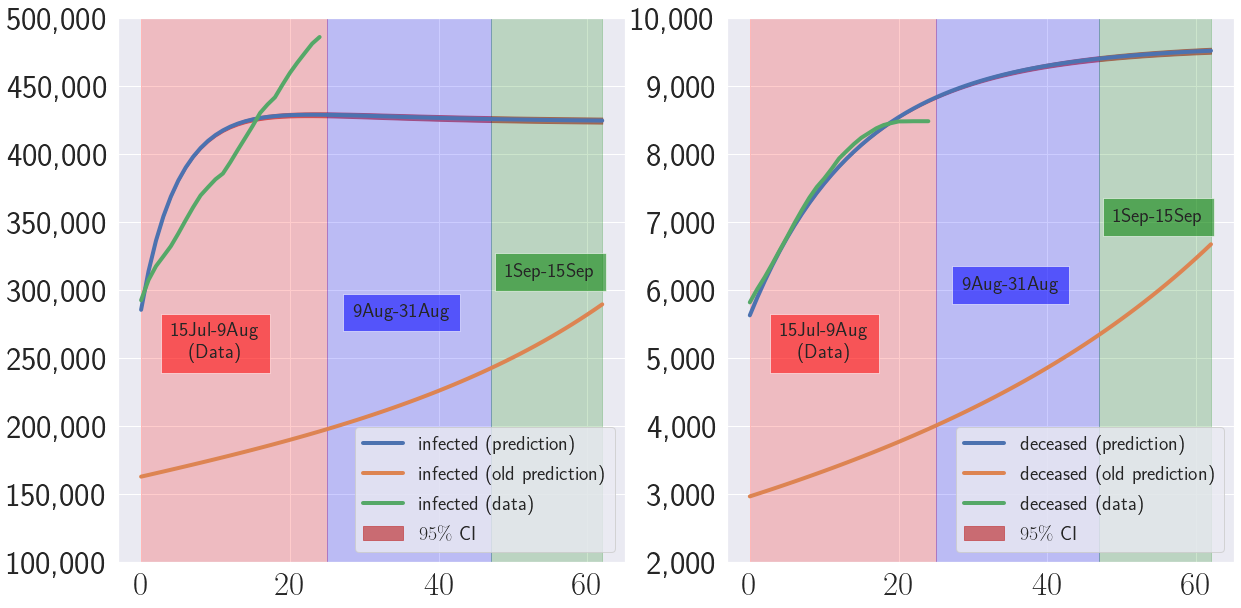

In [273]:
# plot
sns.set(font_scale=3)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# infected
axs[0].plot(pred_state[:, 0], label = r'infected (prediction)', linewidth = 4)
axs[0].plot(pred_old_state[:, 0], label = r'infected (old prediction)', linewidth = 4)
axs[0].plot(calib_data[:,0], label = r'infected (data)', linewidth = 4)

axs[0].fill_between(np.arange(63), total_qoi_evolution[:, -1, 0, 0] + total_qoi_evolution[:, -1, 2, 0],\
                         total_qoi_evolution[:, -1, 0, 0] - total_qoi_evolution[:, -1, 2, 0],\
                         alpha=0.8, edgecolor='r', facecolor='r', label = r'$95\%$ CI')

# axs[0].arrow(14, calib_data[14,0], 2, -0.1*calib_data[14,0], 
#              width=1, edgecolor='green', shape='right', head_width = 5)
# axs[0].text(17, 0.8*calib_data[15,0], "data", ha='center', fontsize=20, 
#             bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

axs[0].text(10, 250000, "15Jul-9Aug\n(Data)", ha='center', fontsize=20, 
            bbox={'facecolor': 'red', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=25, linewidth=1.5, alpha=0.75, color='r')
axs[0].axvspan(0, 25, alpha=0.2, color='red')

axs[0].text(35, 280000, "9Aug-31Aug", ha='center', fontsize=20, 
            bbox={'facecolor': 'blue', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=47, linewidth=1.5, alpha=0.75, color='b')
axs[0].axvspan(25, 47, alpha=0.2, color='blue')

axs[0].text(55, 310000, "1Sep-15Sep", ha='center', fontsize=20, 
            bbox={'facecolor': 'green', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=62, linewidth=1.5, alpha=0.75, color='g')
axs[0].axvspan(47, 62, alpha=0.2, color='green')

axs[0].legend(fontsize = 20, fancybox=True)

axs[0].set_ylim(100000, 500000)
axs[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# deceased
axs[1].plot(pred_state[:, 1], label = r'deceased (prediction)', linewidth = 4)
axs[1].plot(pred_old_state[:, 1], label = r'deceased (old prediction)', linewidth = 4)
axs[1].plot(calib_data[:,1], label = r'deceased (data)', linewidth = 4)

axs[1].fill_between(np.arange(63), total_qoi_evolution[:, -1, 0, 1] + total_qoi_evolution[:, -1, 2, 1],\
                         total_qoi_evolution[:, -1, 0, 1] - total_qoi_evolution[:, -1, 2, 1],\
                         alpha=0.8, edgecolor='r', facecolor='r', label = r'$95\%$ CI')

axs[1].text(10, 5000, "15Jul-9Aug\n(Data)", ha='center', fontsize=20, 
            bbox={'facecolor': 'red', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=25, linewidth=1.5, alpha=0.75, color='r')
axs[1].axvspan(0, 25, alpha=0.2, color='red')

axs[1].text(35, 6000, "9Aug-31Aug", ha='center', fontsize=20, 
            bbox={'facecolor': 'blue', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=47, linewidth=1.5, alpha=0.75, color='b')
axs[1].axvspan(25, 47, alpha=0.2, color='blue')

axs[1].text(55, 7000, "1Sep-15Sep", ha='center', fontsize=20, 
            bbox={'facecolor': 'green', 'alpha': 0.55, 'pad': 10})
# axs[0].axvline(x=62, linewidth=1.5, alpha=0.75, color='g')
axs[1].axvspan(47, 62, alpha=0.2, color='green')

axs[1].legend(fontsize = 20, fancybox=True)

axs[1].set_ylim(2000, 10000)
axs[1].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


# plt.savefig('new_prediction_until_15Sep_mcmc_9.png')
plt.show()

# Plot top five district QoI

In [274]:
district_names = [r'Paris',r'Fort Worth',r'Wichita Falls', r'Amarillo', r'Lubbock', r'Odessa',\
                  r'San Angelo', r'Abilene', r'Waco', r'Tyler', r'Lufkin', r'Houston', r'Yoakum',\
                  r'Austin', r'San Antonio', r'Corpus Christi', r'Bryan', r'Dallas', r'Atlanta',\
                  r'Beaumont', r'Pharr', r'Laredo', r'Brownwood', r'El Paso', r'Childress']

In [275]:
top_district = [1, 14, 13, 17, 11]
for i in range(5):
    print(district_names[top_district[i]])

Fort Worth
San Antonio
Austin
Dallas
Houston


In [276]:
cmap_five_dist = []
for i in range(5):
    cmap_five_dist.append(np.random.rand(3,))

In [277]:
cmap_five_dist = ['']

In [278]:
import matplotlib.cm as cm
import random

In [279]:
dist_colors = cm.viridis(np.linspace(0, 1, 1000))

In [280]:
cmap_five_dist = random.choices(dist_colors, k=5)

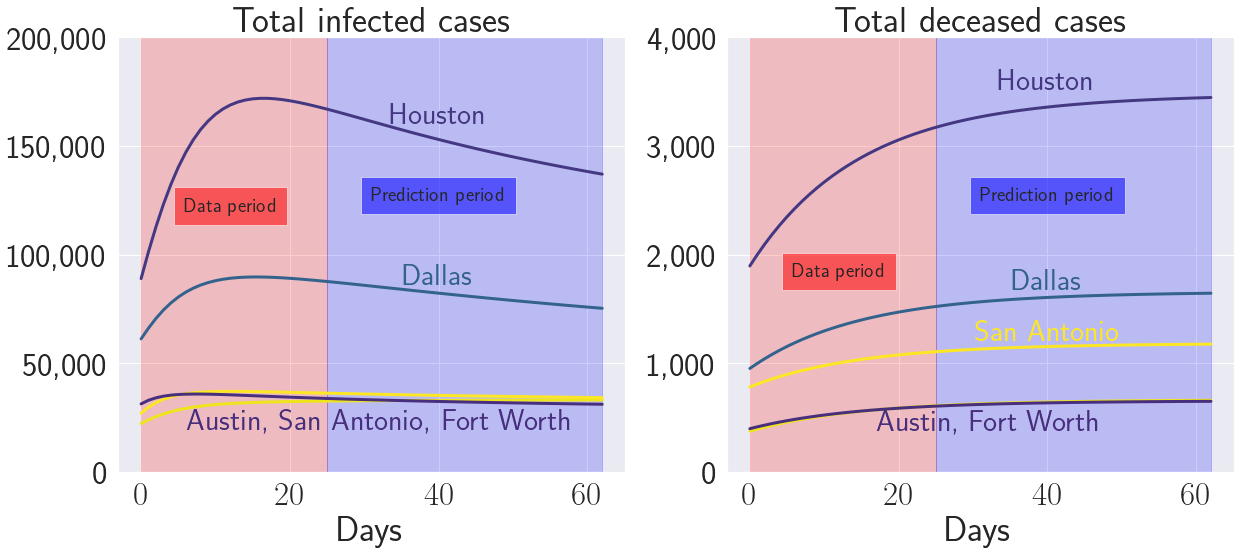

In [317]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,8))

for col in range (2):
    for i in range(5):
        ax[col].plot(np.arange(63), total_qoi_evolution[:, top_district[i], 0, col],\
                     label = district_names[top_district[i]], linewidth = 3, color=cmap_five_dist[i])
        
        #ax[col].text(40, total_qoi_evolution[40, top_district[i], 0, col], \
        #            district_names[top_district[i]], \
        #             ha='center', fontsize=30, color=cmap_five_dist[i])

        ax[col].set_xlabel(r"Days")


ax[0].axvspan(0, 25, alpha=0.2, color='red')
ax[0].axvspan(25, 62, alpha=0.2, color='blue')
ax[0].text(12, 120000, "Data period", ha='center', fontsize=20, 
            bbox={'facecolor': 'red', 'alpha': 0.55, 'pad': 10})
ax[0].text(40, 125000, "Prediction period", ha='center', fontsize=20, 
            bbox={'facecolor': 'blue', 'alpha': 0.55, 'pad': 10})
# ax[0].legend(loc="upper left", ncol = 2, fontsize = 20, fancybox=True)
ax[0].set_ylim(0, 200000)
ax[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0].set_title(r"Total infected cases")


# set district names
dist_id = 4
ax[0].text(40, 1.05*total_qoi_evolution[40, top_district[dist_id], 0, 0], 
           district_names[top_district[dist_id]], ha='center', fontsize=30, color=cmap_five_dist[dist_id])

dist_id = 3
ax[0].text(40, 1.05*total_qoi_evolution[40, top_district[dist_id], 0, 0], 
           district_names[top_district[dist_id]], ha='center', fontsize=30, color=cmap_five_dist[dist_id])

dist_id = 2
dist_names = district_names[top_district[2]] + ", " + district_names[top_district[1]] \
                + ", " + district_names[top_district[0]] 
ax[0].text(32, 0.6*total_qoi_evolution[40, top_district[dist_id], 0, 0], 
           dist_names, ha='center', fontsize=30, color=cmap_five_dist[dist_id])


ax[1].axvspan(0, 25, alpha=0.2, color='red')
ax[1].axvspan(25, 62, alpha=0.2, color='blue')
ax[1].text(12, 1800, "Data period", ha='center', fontsize=20, 
            bbox={'facecolor': 'red', 'alpha': 0.55, 'pad': 10})
ax[1].text(40, 2500, "Prediction period", ha='center', fontsize=20, 
            bbox={'facecolor': 'blue', 'alpha': 0.55, 'pad': 10})
# ax[1].legend(loc="upper left", ncol = 2, fontsize = 20, fancybox=True)
ax[1].set_ylim(0, 4000)
ax[1].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].set_title(r"Total deceased cases")

# set district names
dist_id = 4
ax[1].text(40, 1.05*total_qoi_evolution[40, top_district[dist_id], 0, 1], 
           district_names[top_district[dist_id]], ha='center', fontsize=30, color=cmap_five_dist[dist_id])

dist_id = 3
ax[1].text(40, 1.05*total_qoi_evolution[40, top_district[dist_id], 0, 1], 
           district_names[top_district[dist_id]], ha='center', fontsize=30, color=cmap_five_dist[dist_id])

dist_id = 1
ax[1].text(40, 1.05*total_qoi_evolution[40, top_district[dist_id], 0, 1], 
           district_names[top_district[dist_id]], ha='center', fontsize=30, color=cmap_five_dist[dist_id])

dist_id = 2
dist_names = district_names[top_district[2]] + ", " + district_names[top_district[0]]
ax[1].text(32, 0.6*total_qoi_evolution[40, top_district[dist_id], 0, 1], 
           dist_names, ha='center', fontsize=30, color=cmap_five_dist[dist_id])


plt.savefig("new_prediction_top_five_district_vline_mcmc_9.png",bbox_inches = "tight")
plt.show()

In [15]:
cmap_dist = []
for i in range(25):
    cmap_dist.append(np.random.rand(3,))

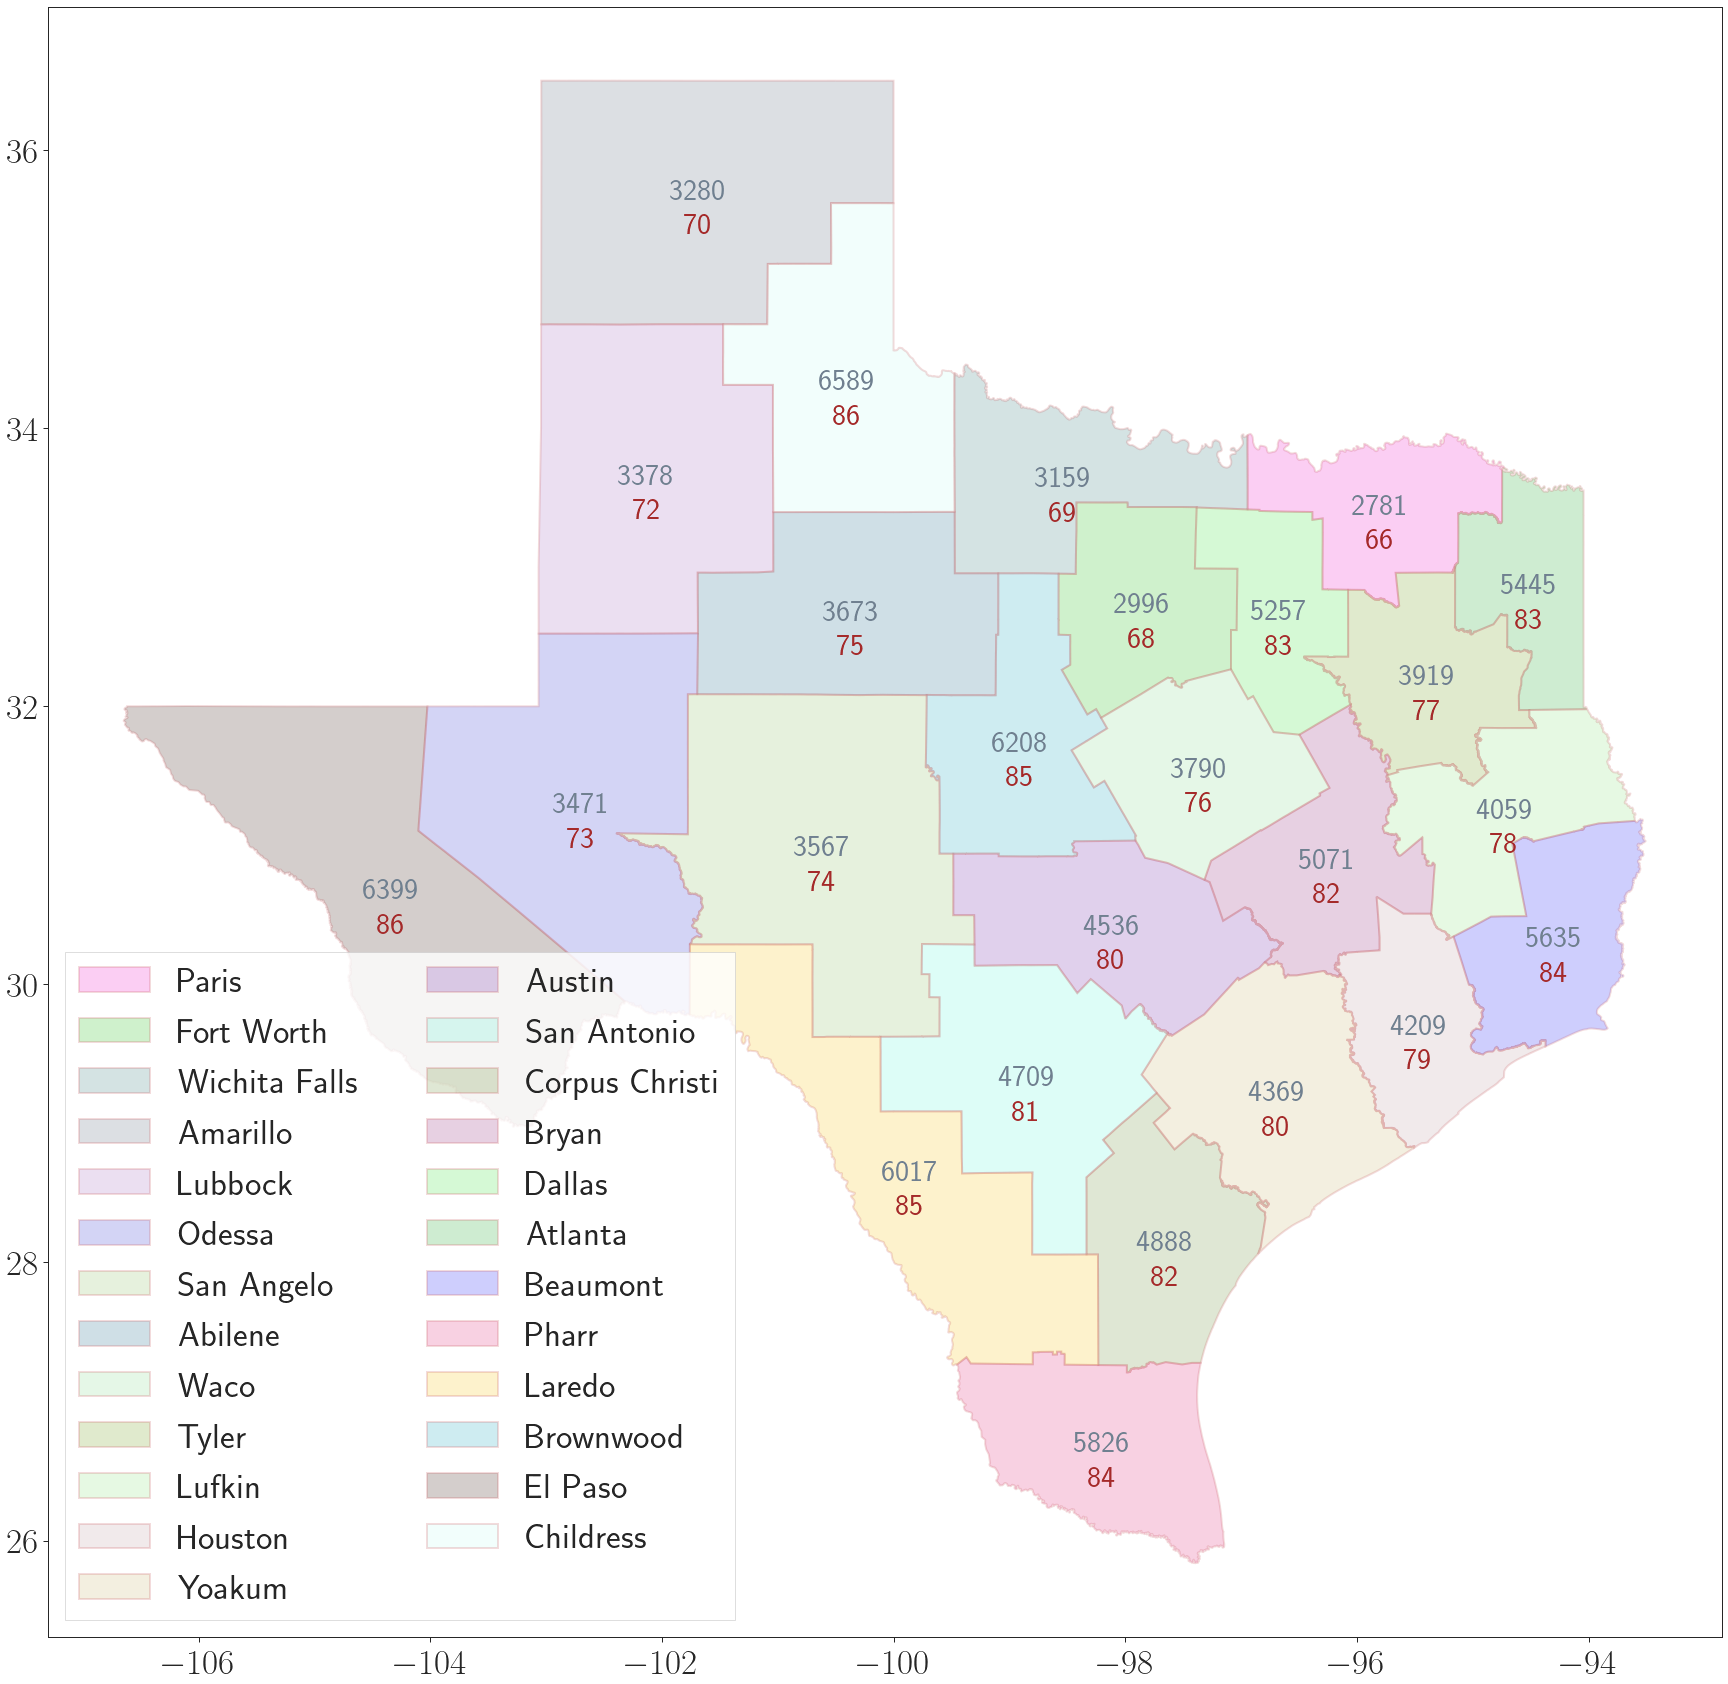

In [63]:
from descartes import PolygonPatch
sns.set_style("ticks")

fig = plt.figure(figsize=(30, 30))
plt.autoscale(enable=True, axis='both')
plt.gca().set_facecolor("white")

district_names = [r'Paris',r'Fort Worth',r'Wichita Falls', r'Amarillo', r'Lubbock', r'Odessa',\
                  r'San Angelo', r'Abilene', r'Waco', r'Tyler', r'Lufkin', r'Houston', r'Yoakum',\
                  r'Austin', r'San Antonio', r'Corpus Christi', r'Bryan', r'Dallas', r'Atlanta',\
                  r'Beaumont', r'Pharr', r'Laredo', r'Brownwood', r'El Paso', r'Childress']

# prediction time (last day)

# Sep 1
# prediction_time = 47

# Sep 15
prediction_time = 62

def get_point(i, nodes):
    return [nodes[i][0], nodes[i][1]]

def get_tri_nodes(i, nodes, elems):
    vx = []
    vy = []
    for j in range(3):
        v = get_point(elems[4*i+j+1], nodes)
        vx.append(v[0])
        vy.append(v[1])
        
    return vx, vy

def get_polygon(i, nodes, elems):
    
    v1 = get_point(elems[4*i+1], nodes)
    v2 = get_point(elems[4*i+2], nodes)
    v3 = get_point(elems[4*i+3], nodes)
    #return Polygon(((v1[0], v1[1]), (v2[0], v2[1]), (v3[0], v3[1])))
    #return Polygon([v1, v2, v3], closed=False, color=np.random.rand(3,), alpha=0.5, fill=True, edgecolor=None)
    return Polygon([v1, v2, v3], closed=False, alpha=0.5, fill=True, edgecolor=None)

def plot_tri():
    for i in range(mesh.n_cells):
        #ax.add_patch(get_polygon(i, mesh_nodes, mesh_elems))
        tri = get_polygon(i, mesh_nodes, mesh_elems)
        plt.gca().add_patch(tri)

        vx, vy = get_tri_nodes(i, mesh_nodes, mesh_elems)
        vx_mid = np.mean(vx)
        vy_mid = np.mean(vy)
        #plt.text(vx_mid, vy_mid, str(i), fontsize=8)
        
def plot_dist():
    ax = fig.gca() 
    for i in range(len(new_dist_geom)):
        poly = new_dist_geom[i]
        ax.add_patch(PolygonPatch(poly, fill=True, fc=cmap_dist[i], 
                        ec='r', alpha=0.2, zorder=2, linewidth=2, label = district_names[i]))
        
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0], 
                 str(int(pred_qoi[prediction_time, i, 0, 0])), 
                 ha='center', va='center', fontsize='30', color='slategrey', fontweight='bold')
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0] - 0.25, 
                 str(int(pred_qoi[prediction_time, i, 0, 1])), 
                 ha='center', va='center', fontsize='30', color='brown', fontweight='bold')
    


# plot_tri()
plot_dist()
plt.legend(ncol = 2, fancybox=False)
# plt.title('District-wise prediction on {}'.format(get_sim_date(prediction_time+1).date()))
# plt.savefig('map_plot_cases_in_district_{}.png'.format(get_sim_date(prediction_time+1).date()))
plt.show()

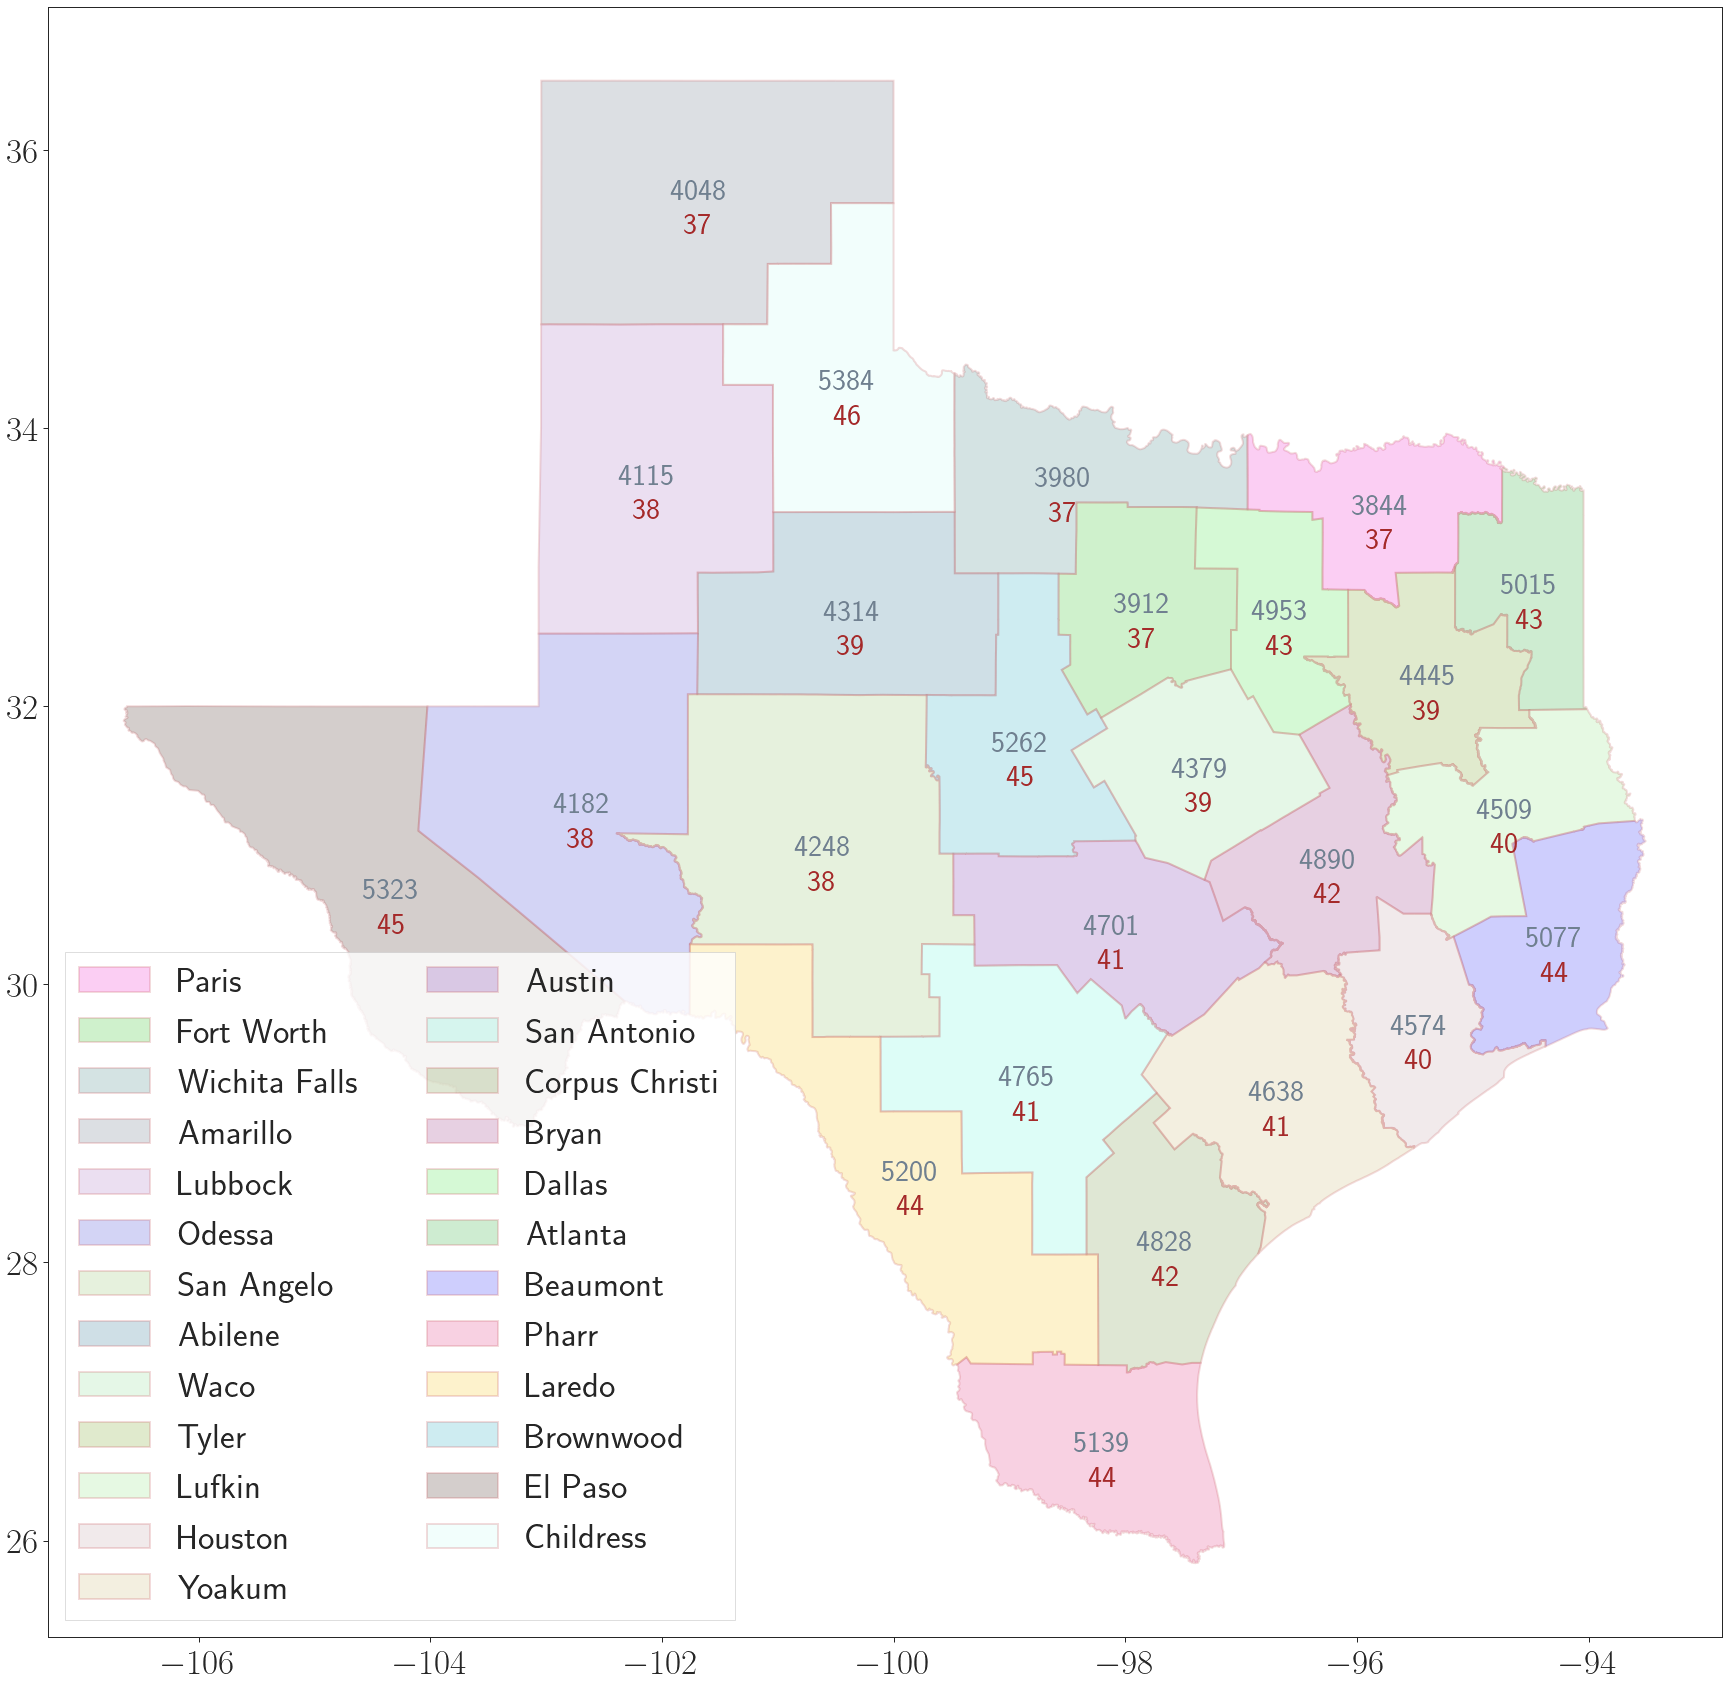

In [64]:
from descartes import PolygonPatch
sns.set_style("ticks")

fig = plt.figure(figsize=(30, 30))
plt.autoscale(enable=True, axis='both')
plt.gca().set_facecolor("white")

district_names = [r'Paris',r'Fort Worth',r'Wichita Falls', r'Amarillo', r'Lubbock', r'Odessa',\
                  r'San Angelo', r'Abilene', r'Waco', r'Tyler', r'Lufkin', r'Houston', r'Yoakum',\
                  r'Austin', r'San Antonio', r'Corpus Christi', r'Bryan', r'Dallas', r'Atlanta',\
                  r'Beaumont', r'Pharr', r'Laredo', r'Brownwood', r'El Paso', r'Childress']

# prediction time (last day)

# Sep 1
# prediction_time = 47

# Sep 15
prediction_time = 62

def get_point(i, nodes):
    return [nodes[i][0], nodes[i][1]]

def get_tri_nodes(i, nodes, elems):
    vx = []
    vy = []
    for j in range(3):
        v = get_point(elems[4*i+j+1], nodes)
        vx.append(v[0])
        vy.append(v[1])
        
    return vx, vy

def get_polygon(i, nodes, elems):
    
    v1 = get_point(elems[4*i+1], nodes)
    v2 = get_point(elems[4*i+2], nodes)
    v3 = get_point(elems[4*i+3], nodes)
    #return Polygon(((v1[0], v1[1]), (v2[0], v2[1]), (v3[0], v3[1])))
    #return Polygon([v1, v2, v3], closed=False, color=np.random.rand(3,), alpha=0.5, fill=True, edgecolor=None)
    return Polygon([v1, v2, v3], closed=False, alpha=0.5, fill=True, edgecolor=None)

def plot_tri():
    for i in range(mesh.n_cells):
        #ax.add_patch(get_polygon(i, mesh_nodes, mesh_elems))
        tri = get_polygon(i, mesh_nodes, mesh_elems)
        plt.gca().add_patch(tri)

        vx, vy = get_tri_nodes(i, mesh_nodes, mesh_elems)
        vx_mid = np.mean(vx)
        vy_mid = np.mean(vy)
        #plt.text(vx_mid, vy_mid, str(i), fontsize=8)
        
def plot_dist():
    ax = fig.gca() 
    for i in range(len(new_dist_geom)):
        poly = new_dist_geom[i]
        ax.add_patch(PolygonPatch(poly, fill=True, fc=cmap_dist[i], 
                        ec='r', alpha=0.2, zorder=2, linewidth=2, label = district_names[i]))
        
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0], 
                 str(int(pred_old_qoi[prediction_time, i, 0, 0])), 
                 ha='center', va='center', fontsize='30', color='slategrey', fontweight='bold')
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0] - 0.25, 
                 str(int(pred_old_qoi[prediction_time, i, 0, 1])), 
                 ha='center', va='center', fontsize='30', color='brown', fontweight='bold')
    


# plot_tri()
plot_dist()
plt.legend(ncol = 2, fancybox=False)
# plt.title('District-wise prediction on {}'.format(get_sim_date(prediction_time+1).date()))
# plt.savefig('map_plot_cases_in_district_{}.png'.format(get_sim_date(prediction_time+1).date()))
plt.show()